In [1]:
import numpy as np
import time
from IPython.display import clear_output

In [2]:
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt

In [3]:
def alive_wealth_histogram(env):
    w = []
    for i in env.agents:
        w += [i.sugar]
    plt.hist(w,bins=20,density=True)
    plt.show()
    
    
def alive_age_histogram(env):
    w = []
    for i in env.agents:
        w += [i.steps_old/2]
    plt.hist(w,bins=20,density=True)
    plt.show()

In [4]:
class Simple_Agent:
    def __init__(self,environment,posx,posy):
        self.environment = environment
        self.posx = posx
        self.posy = posy
        self.life = np.random.normal(80, 5, None)
        self.sugar = 10
        self.vision = 5
        self.habilidade = 4
        self.metabolismo = 2
        self.total_balance = 0
        self.steps_old = 0
        self.children = []
    
    def get_vision(self):
        vision = np.zeros((2*self.vision+1,2*self.vision+1))
        i_vision =0
        j_vision =0
        for i in range(self.posx - self.vision, self.posx + self.vision + 1):
            for j in range(self.posy - self.vision, self.posy + self.vision + 1):
                vision[i_vision][j_vision] = self.environment.get_resource_square(i,j)
                j_vision += 1
            j_vision = 0
            i_vision+=1
        return vision

    def move(self):
        self.vision = 2 + int(self.sugar/5)
        self.habilidade = 3 + int(self.sugar/5)
        vision = self.get_vision()
        x = 0
        y=0
        maior = 0
        # Caso Normal
        for i in range(-1,2):
            for j in range(-1,2):
                atual = vision[self.vision+i][self.vision+j]
                if atual > maior:
                    maior = atual
                    x = i
                    y = j
        if maior > 0:
            return x,y
                
        # Caso Heuristica
        x = 0
        y = 0
        cima = np.sum(vision[:self.vision + 1])
        baixo = np.sum(vision[self.vision:])
        if cima > baixo :
            y = -1
        elif cima<baixo:
            y = 1
            
        cima = np.sum(vision.transpose()[:self.vision + 1])
        baixo = np.sum(vision.transpose()[self.vision:])
        if cima > baixo :
            x = -1
        elif cima<baixo :
            x = 1
        
        if x == 0 and y ==0:
            #caso random
            x = np.random.random()*2 - 1
            x = int(x/abs(x))
            y = np.random.random()*2 - 1
            y = int(y/abs(y))
        return y,x
    
    def add_resource(self, qtd):
        self.sugar += qtd
    
    def life_step(self):
        self.steps_old +=1
        self.total_balance += self.sugar
        if self.sugar > self.metabolismo:
            self.sugar -= self.metabolismo
            self.life -= 0.5
        else:
            self.environment.fome +=1 
            self.life -= 1.5
            
    def status(self):
        print("life ", np.round(self.life), "sugar", np.round(self.sugar))
            

In [5]:
def generate_sin_resource_grid(size, step):
        step_grid = step
        grid_size = size
        res = np.zeros((size,size))
        half_size_interval = np.pi*grid_size/20
        a = 0
        b = 0
        seed = np.random.random()/4
        cnst_de_frequencia = 75/size
        for i in np.arange(-half_size_interval,half_size_interval,2*half_size_interval/grid_size):
            i = i*cnst_de_frequencia


            for j in np.arange(-half_size_interval,half_size_interval,2*half_size_interval/grid_size):
                j = j*cnst_de_frequencia
                r = np.sin(i + i*seed + step_grid ) + np.sin(j -j*seed+ step_grid) + np.sin(i+j+ i*seed/10 + j*seed/10 +step_grid) - np.sin(i-j+ step_grid)
                if r < 0:
                    r =0
                res[a][b] = r
                b += 1
            a += 1
            b = 0
        return res

In [6]:
def grid_rayleigh(size,mu):
    res = np.random.rayleigh(mu,(size,size)).astype(np.int)
    res = res.clip(min=0)
    return res

In [7]:
def grid_random_mask(size,n_clusters,cluster_size):
    if cluster_size>size:
        return None
    res = np.zeros((size+2*cluster_size,size+2*cluster_size),dtype=np.int)
    cluster = np.ones((cluster_size,cluster_size),dtype=np.int)
    for i in range(n_clusters):
        x,y = np.random.randint(cluster_size,size+cluster_size,2)
        res[x:x+cluster_size,y:y+cluster_size] = cluster
    
    return res[cluster_size:cluster_size+size,cluster_size:cluster_size+size]

In [8]:
def grid_random_points_mask(size, n):
    res = np.zeros((size,size))
    random_points = np.random.randint(0,size,(n,2))
    for p in random_points:
        res[p[0]][p[1]] = 1
    return res

In [9]:
class Environment:
    def __init__(self,size,n_agents,step_for_resources = 5):
        self.size = size
        
        self.grid_players = np.zeros((size,size))
        self.grid_resources = np.zeros((size,size))
        self.step_for_resources = step_for_resources
        
        self.cluster_n = 5
        self.cluster_size = 10
        self.cluster_renew_time = 5
        self.grid_production_mask = grid_random_mask(self.size,self.cluster_n,self.cluster_size)
        
        self.random_points_number = 50
        
        self.agents = []
        self.n_agents = n_agents
        self.dead_agents = []
        
        
        self.step_counter = 0
        
        self.mean_sugar_production_per_square = 1                
        self.sazonality_amplitude = 5
        self.sazonality_period = 5
        
        self.depreciation_percentage = 0.5
        self.depreciation = 1
        
        self.birth_rate = 0.01

        
        self.fome = 0
        
    def get_available_position_on_grid(self):
        pos = np.random.randint(self.size,size=2)
        while self.grid_players[pos[0]][pos[1]]==1:
            pos = np.random.randint(self.size,size=2)
        return pos
    
    def get_available_position_on_grid_next_to(self,posx,posy):
        i = 0
        minimo = 10
        x = posx
        y = posy
        while self.grid_players[posx][(posy + i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy + i
            
            
        while self.grid_players[posx][(posy - i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy - i
            
        while self.grid_players[(posx+i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx+i
            y = posy
            
        while self.grid_players[(posx - i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx -i
            y = posy
        return (x,y)
    

    def get_resource_square(self,x,y):
        return self.grid_resources[x%self.size][y%self.size]
    
    def init_simple_agent(self,sugar=5):
        pos = self.get_available_position_on_grid()
        tmp = Simple_Agent(self,pos[0],pos[1])
        tmp.sugar = sugar
        self.agents += [tmp]
        return tmp
        
    def init_agents(self):
        for i in range(self.n_agents):
            self.init_simple_agent();
        
    def init_ordered_grid(self):
        for i in range(self.size):
            for j in range(self.size):
                self.grid_resources[i][j] = i*self.size + j
            
    def init_normal_random_grid(self,mu, var):
        for i in range(self.size):
            for j in range(self.size):
                tmp = np.random.normal(mu,var)//1
                if tmp > 0:
                    self.grid_resources[i][j] = tmp

    def mapa(self):
        mapa = np.zeros((self.size,self.size))
        for i in self.agents:
            mapa[i.posx][i.posy] = 1
        print(mapa)

    def resources(self):
        print(self.grid_resources)
        
    def pmapa(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.grid_players[i][j] == 1:
                    print("(",int(self.grid_resources[i][j]),")\t", end= " ")
                else:
                    print(" ",int(self.grid_resources[i][j])," \t", end= " ")
            print("")
            
            
    def grid_step(self):
        # Mask renew
        if self.step_counter%self.cluster_renew_time == 0:
            self.grid_production_mask = grid_random_mask(self.size,self.cluster_n,self.cluster_size)
        
        # Depreciation
        
        self.grid_resources = self.grid_resources - self.depreciation*grid_random_points_mask(self.size,int(self.depreciation_percentage*self.size**2))
        self.grid_resources = self.grid_resources.clip(min=0)
        
        # Sazonality
        freq = 2*np.pi*self.step_counter/self.sazonality_period
        sazonal_sugar_production_mean = self.mean_sugar_production_per_square*(100 + self.sazonality_amplitude*np.sin(freq))/100
        
        # Adding resources
        full_harvest = grid_rayleigh(self.size, sazonal_sugar_production_mean)
        if self.step_counter%self.step_for_resources==0:
            rnd_mask = np.logical_or(self.grid_production_mask,grid_random_points_mask(self.size,self.random_points_number))
            self.grid_resources += full_harvest*rnd_mask
        else:    
            self.grid_resources += full_harvest*grid_random_points_mask(self.size,self.random_points_number)

        
#     def renew_grid(self):
#         #depreciacao
#         self.grid_resources = self.grid_resources*(1-self.depreciation)
#         self.grid_resources = self.grid_resources.clip(min=0)
            
#         new_resources = generate_sin_resource_grid(self.size,self.grid_counter/2)
#         soma_total = np.sum(new_resources)
        
#         while soma_total > self.max_sugar_production:
#             x = int(np.random.random()*self.size)
#             y = int(np.random.random()*self.size)
#             soma_total -= new_resources[x][y]
#             new_resources[x][y] = 0
            
#         #sazonalidade
#         new_resources = new_resources*(100 + self.sazonality_percentage*np.sin(self.grid_counter/4))/100
            
            
#         self.grid_counter += 1
#         print("total comida adicionados ", np.sum(new_resources), np.sum(self.grid_resources))
#         self.grid_resources += new_resources
        
    def gini(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0

        for i in w:
            total += i
            gini += total*base_length


        gini = gini/total
        gini = (0.5 - gini)*2
        return gini
    
    def lorentz_curve(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0
        for i in w:
            total += i
            gini += total*base_length
            curve += [total]
        curve = curve/total


        plt.plot(np.arange(0,1,1/len(curve)),curve)
        plt.plot([0,np.max(curve)],[0,np.max(curve)])
        plt.show()

                        
    def step(self):
        
        if len(self.agents)<=0:
            return

        i = 0
        vivos = []
        
        #Add Resources To Grid    
        self.grid_step()
        self.fome = 0
        for agent in self.agents:
            
            # Move
            (x,y)  = agent.move()
            (px,py) = ((agent.posx + x)%self.size, (agent.posy + y)%self.size)

            if self.grid_players[px][py] != 1:
                self.grid_players[agent.posx][agent.posy] = 0
                agent.posx = px
                agent.posy = py
                self.grid_players[px][py] = 1
            
            
            
            # Get Resource
            r = self.grid_resources[agent.posx,agent.posy]
            if r > agent.habilidade:
                agent.add_resource(agent.habilidade)
                self.grid_resources[agent.posx,agent.posy] -=agent.habilidade
            else:
                agent.add_resource(self.grid_resources[agent.posx,agent.posy])
                self.grid_resources[agent.posx,agent.posy] = 0
                
                
                
            # Life step
            agent.life_step()
            
            if np.random.random()<self.birth_rate:
                self.get_available_position_on_grid_next_to(agent.posx,agent.posy)
                child = self.init_simple_agent(agent.sugar*0.8)
                agent.children += [child]
                agent.sugar = agent.sugar*0.8
            
                
            
            #Death Time
            if agent.life >0:
                vivos += [agent]
            else:                
                if len(agent.children)>0:
                    inheritance = int(agent.sugar/len(agent.children))
                    for c in agent.children:
                        c.sugar += inheritance
                self.dead_agents += [agent]
                self.grid_players[agent.posx][agent.posy] = 0
            i+=1
            
        #Add live agents 
        self.agents = vivos
        
#         # Add new Agents
#         while len(self.agents)<self.n_agents:
#             self.init_simple_agent()
        
        self.step_counter += 1

# Exemplo 1

In [10]:
size = 50
a = Environment(size,100)
a.init_agents()

a.step()
a0 = len(a.agents)
b0 = np.sum(a.grid_resources)
c0 = a.fome


a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1


## Evolução dos agregados

pp = ProgressPlot(line_names=["agents", "sugar stock","Fome","Gini"])   
a0 = len(a.agents)
b0 = np.sum(a.grid_resources)
c0 = a.fome
for i in range(2000):
    if i%10 == 0:
        a1 = len(a.agents)
        b1 = np.sum(a.grid_resources)
        c1 = a.fome
#         pp.update([[(a1-a0)/a0,(b1-b0)/b0,c1/a1]])
        pp.update([[a1,b1/10,c1,a.gini()*1000]])
        a0 = a1
        b0 = b1
        c0 = c1
    a.step()
pp.finalize()


## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)



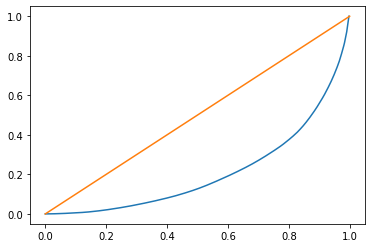

0.581178534063


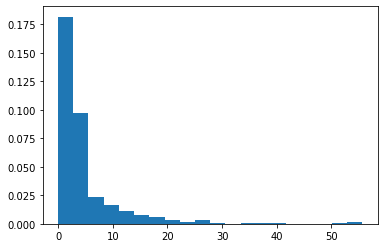

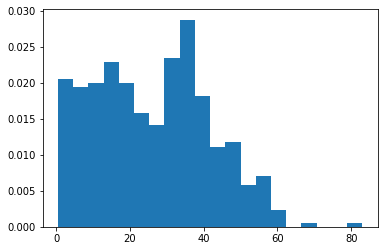

In [16]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

In [38]:
a = Environment(50,100,step_for_resources=5)
a.max_sugar_production = 1000
a.init_agents()
a.birth_rate = 0.015
pp = ProgressPlot(line_names=["agents", "sugar stock","Gini Index"])

for i in range(400):
    a.step()
    if i%10 == 0:
        print(len(a.agents))
        pp.update([[len(a.agents),np.sum(a.grid_resources)/10,a.gini()*100]])
    
pp.finalize()

105
128
147
163
184
199
138
130
113
114
121
106
96
96
95
84
80
79
81
66
63
58
46
36
37
34
29
25
24
22
23
23
21
30
34
26
26
26
28
24


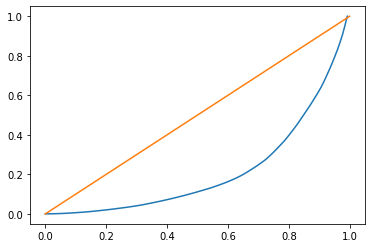

0.576902983471


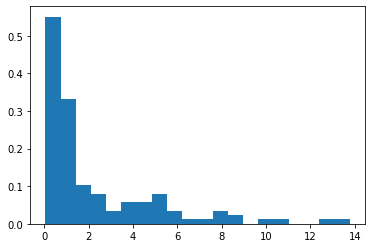

In [84]:
a = Environment(10,1,step_for_resources=3)

a.cluster_n = 2
a.cluster_size = 2
a.cluster_renew_time = 4

a.random_points_number = 2

a.mean_sugar_production_per_square = 2

a.init_agents()
for i in range(100):
    time.sleep(3)
    clear_output(wait=True)
    a.pmapa()
    a.step()

  0  	   0  	   0  	   0  	   0  	   1  	   0  	   0  	   0  	   0  	 
  0  	   0  	   2  	   2  	   0  	   0  	   0  	   0  	   0  	   6  	 
  0  	   0  	   0  	   2  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   2  	   1  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	 ( 0 )	   0  	   4  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   1  	   3  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 


KeyboardInterrupt: 